In [1]:
import pandas as pd
import networkx as nx
import igraph as ig
import random as rand
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from igraph import *

## Load the data

We conly use the __wikipedia__ dataset here

In [2]:
'''
Cell with code used to parse the wiki data.
'''

filename = "Data/wikiElec.ElecBs3.txt"

with open(filename, errors = 'ignore') as f:
    lines = f.readlines()
    
'''
After opening the file, a list made of the lines of the file is generated, and subsequently treated to have only the lines
featuring the voted person and the people that vote.
'''
    
lines = [x.strip() for x in lines]

splines = [i.split('\t') for i in lines]

parslines = [x for x in splines if (x[0] == 'U' or x[0] == 'V' or x[0] == 'E')]

'''
Then a for loop passes through the whole list, extracting and putting the data of interest in several lists.
'''

fromlist = []
tolist = []
signlist = []
voted_user_id = ''

for line in parslines:
    
    if line[0] == 'U':
        voted_user_id = line[1]
    if ((line[0] == 'V') and (line[1] != '0')):
        fromlist.append(line[2])
        tolist.append(voted_user_id)
        signlist.append(line[1])
        
'''
The dataframe is generated using the aforementioned lists, converted them from string to numeric ones.
'''

wikipedia_df = pd.DataFrame(columns = ['FromNodeId', 'ToNodeId', 'Sign'])

wikipedia_df.FromNodeId = list(map(int,fromlist))
wikipedia_df.ToNodeId = list(map(int,tolist))
wikipedia_df.Sign = list(map(int,signlist))

In [3]:
'''
Cell to do the needed modifications on wikipedia_df.
'''

wikiinv_df = wikipedia_df.reindex(index=wikipedia_df.index[::-1])
wikiinv_df = wikiinv_df.drop_duplicates(subset=['FromNodeId', 'ToNodeId']) 

## Trust propagation functions

In [4]:
'''
This cell converts every dataframe in two graph structures, a networkx and an igraph one, using the function below to
lighten up the code.
'''

def convert_to_graph(df):
    # Input:
    # -- df: a pandas dataframe
    # Output:
    # -- gnx: a networkx graph structure;
    # -- g: a igraph graph structure
    
    gnx = nx.from_pandas_edgelist(df, source = 'FromNodeId', target = 'ToNodeId', edge_attr = 'Sign', 
                                  create_using = nx.DiGraph)
    
    g = ig.Graph.TupleList(gnx.edges(), directed = True)
    
    return gnx, g

wikipedia_gnx, wikipedia_g = convert_to_graph(wikiinv_df)

In [5]:
'''
Function to calculate the trust score
'''

def trust_dispenser(G):
    
    trust = []
    
    for v in G:
        count = 0;
        vnbrs = set(G.pred[v])
        for u in vnbrs:
            
            count += G[u][v]['Sign']
            
        
        trust.append([v, count])

    return trust

In [6]:
def transpose_trust(G,df):
    
    propagation = []
    
    m = {v: i for i, v in enumerate(G)}
    
    for v in G:
        
        vnbrs = set(G.pred[v]) | set(G.succ[v])
        for u in vnbrs:
            if m[u] <= m[v]:
                continue
            neighbors = (vnbrs | set(G.succ[u]) | set(G.pred[u])) - {u, v}
            
            for w in neighbors:
                
                if (m[v] < m[w] < m[u]):
                    
                    if (G.has_edge(v, w) and G.has_edge(u, w)):
                        
                        if not(G.has_edge(v, u)):
                            
                            
                            if (((G[v][w]['Sign'] == 1) and (G[u][w]['Sign'] == 1)) or ((G[v][w]['Sign'] == -1) and (G[u][w]['Sign'] == -1))):
                            
                                V = df.Trust[df.Node == v].to_numpy()
                                U = df.Trust[df.Node == u].to_numpy()
                            
                                if V>U:
                                
                                    propagation.append([v, u, -0.5])
                                if V<U:
                                
                                    propagation.append([v, u, 0.5])
                            if ((G[v][w]['Sign'] == 1) and (G[u][w]['Sign'] == -1)):
                            
                                propagation.append([v, u, 0.5])
                            if ((G[v][w]['Sign'] == -1) and (G[u][w]['Sign'] == 1)):
                            
                                propagation.append([v, u, -0.5])
                                
                        if not(G.has_edge(u, v)):
                            
                                
                            if (((G[v][w]['Sign'] == 1) and (G[u][w]['Sign'] == 1)) or ((G[v][w]['Sign'] == -1) and (G[u][w]['Sign'] == -1))):
                            
                                V = df.Trust[df.Node == v].to_numpy()
                                U = df.Trust[df.Node == u].to_numpy()
                            
                                if V>U:
                                
                                    propagation.append([u, v, 0.5])
                                if V<U:
                                
                                    propagation.append([u, v, -0.5])
                            if ((G[v][w]['Sign'] == 1) and (G[u][w]['Sign'] == -1)):
                            
                                propagation.append([u, v, -0.5])
                            if ((G[v][w]['Sign'] == -1) and (G[u][w]['Sign'] == 1)):
                            
                                propagation.append([u, v, 0.5])
                                
                                

    return propagation

In [7]:
def direct_propagation(G, df):
    
    propagation = []
    
    m = {v: i for i, v in enumerate(G)}
    
    for v in G:
        
        vnbrs = set(G.pred[v]) | set(G.succ[v])
        for u in vnbrs:
            if m[u] <= m[v]:
                continue
            neighbors = (vnbrs | set(G.succ[u]) | set(G.pred[u])) - {u, v}
            
            for w in neighbors:
                
                if (m[v] < m[w] < m[u]):
                    
                    if (G.has_edge(v, w) and G.has_edge(w, u) and not(G.has_edge(v, u))):
                        
                        if ((G[v][w]['Sign'] == 1) and (G[w][u]['Sign'] == 1)):
                            
                            propagation.append([v, u, 0.5])
                        if ((G[v][w]['Sign'] == -1) and (G[w][u]['Sign'] == -1)):
                            
                            propagation.append([v, u, -0.5])
                        if (((G[v][w]['Sign'] == -1) and (G[w][u]['Sign'] == 1)) or ((G[v][w]['Sign'] == 1) and (G[w][u]['Sign'] == -1))):
                            
                            V = df.Trust[df.Node == v].to_numpy()
                            U = df.Trust[df.Node == u].to_numpy()
                            
                            if V>U:
                                
                                propagation.append([v, u, -0.5])
                            if V<U:
                                
                                propagation.append([v, u, 0.5])
                                          
            

    return propagation

### Dispense the trust

In [8]:
'''
Creating the trust score df
'''

trustscore = trust_dispenser(wikipedia_gnx)
trustscore_df = pd.DataFrame(trustscore, columns = ['Node', 'Trust'])
trustscore_df.head()

,Node,Trust
0,3404,81
1,6307,-6
2,8243,0
3,6885,0
4,7053,0


### Direct propagation

In [9]:
'''
Create direct propagation df
'''

propagation_dir = direct_propagation(wikipedia_gnx, trustscore_df)
propagation_dir_data = pd.DataFrame(propagation_dir, columns = ['FromNodeId', 'ToNodeId', 'Sign'])
propagation_dir_gnx, propagation_dir_g = convert_to_graph(propagation_dir_data)
propagation_dir_score = trust_dispenser(propagation_dir_gnx)
propagation_dir_df = pd.DataFrame(propagation_dir_score, columns = ['Node', 'Trust'])
propagation_dir_df.head()

,Node,Trust
0,3404,0.0
1,3084,3.0
2,1549,27.0
3,3615,4.0
4,3144,7.0


In [10]:
'''
Merge the dataframes
'''

wiki_direct_df = trustscore_df.merge(propagation_dir_df, how = 'left', left_on = 'Node', right_on = 'Node').fillna(0)
wiki_direct_df

,Node,Trust_x,Trust_y
0,3404,81,0.0
1,6307,-6,0.0
2,8243,0,0.0
3,6885,0,0.0
4,7053,0,0.0
...,...,...,...
7113,85,0,0.0
7114,84,0,0.0
7115,63,0,0.0
7116,61,20,0.0


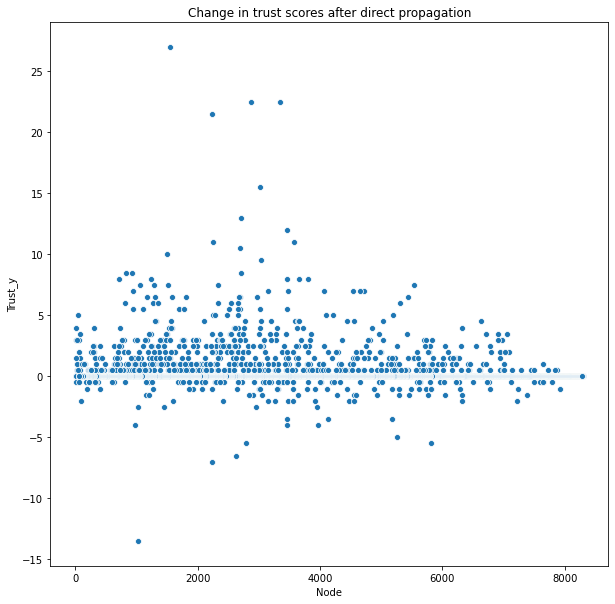

In [11]:
plt.figure(figsize = (10,10))

ax = sns.scatterplot(x= 'Node', y="Trust_y", data=wiki_direct_df)
ax.set_title('Change in trust scores after direct propagation')
plt.show()

### Transpose trust

In [12]:
'''
Create transpose propagation df
'''
propagation_tra = transpose_trust(wikipedia_gnx, trustscore_df)
propagation_tra_data = pd.DataFrame(propagation_tra, columns = ['FromNodeId', 'ToNodeId', 'Sign'])
propagation_tra_gnx, propagation_tra_g = convert_to_graph(propagation_tra_data)
propagation_tra_score = trust_dispenser(propagation_tra_gnx)
propagation_tra_df = pd.DataFrame(propagation_tra_score, columns = ['Node', 'Trust'])
propagation_tra_df

,Node,Trust
0,3586,18.5
1,3404,1.0
2,2565,51.0
3,11,-169.0
4,3084,1.5
...,...,...
2684,45,-1.0
2685,40,0.5
2686,342,-0.5
2687,677,0.0


In [13]:
'''
Merge the dataframes
'''

wiki_tra_df = trustscore_df.merge(propagation_tra_df, how = 'left', left_on = 'Node', right_on = 'Node').fillna(0)
wiki_tra_df['Trust'] = (wiki_tra_df.Trust_x + wiki_tra_df.Trust_y)
wiki_tra_df

,Node,Trust_x,Trust_y,Trust
0,3404,81,1.0,82.0
1,6307,-6,0.0,-6.0
2,8243,0,-0.5,-0.5
3,6885,0,-1.5,-1.5
4,7053,0,-0.5,-0.5
...,...,...,...,...
7113,85,0,0.0,0.0
7114,84,0,0.0,0.0
7115,63,0,0.0,0.0
7116,61,20,0.0,20.0


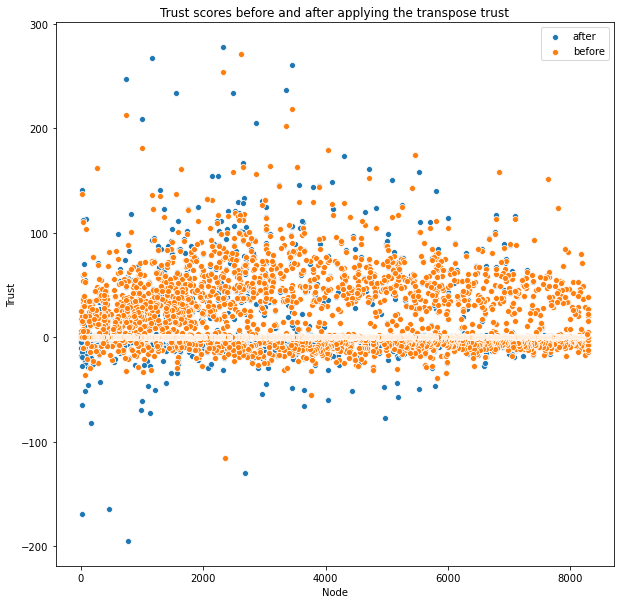

In [14]:
plt.figure(figsize = (10,10))

ax = sns.scatterplot(x= 'Node', y="Trust", data=wiki_tra_df, label='after')
ax = sns.scatterplot(x= 'Node', y="Trust", data=trustscore_df, label='before')
ax.set_title("Trust scores before and after applying the transpose trust")
plt.show()

Text(0.5, 1.0, 'Change in trust scores after applying the transpose trust')

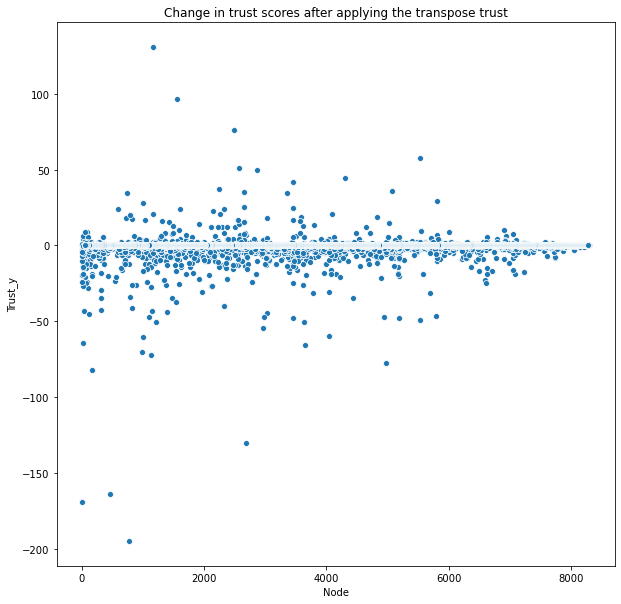

In [17]:
plt.figure(figsize = (10,10))

ax = sns.scatterplot(x= 'Node', y="Trust_y", data=wiki_tra_df)
ax.set_title("Change in trust scores after applying the transpose trust")

# From now on the quality drops! (not corrected, just tests)

Text(0.5, 1.0, 'Heatmap of the original wiki dataset')

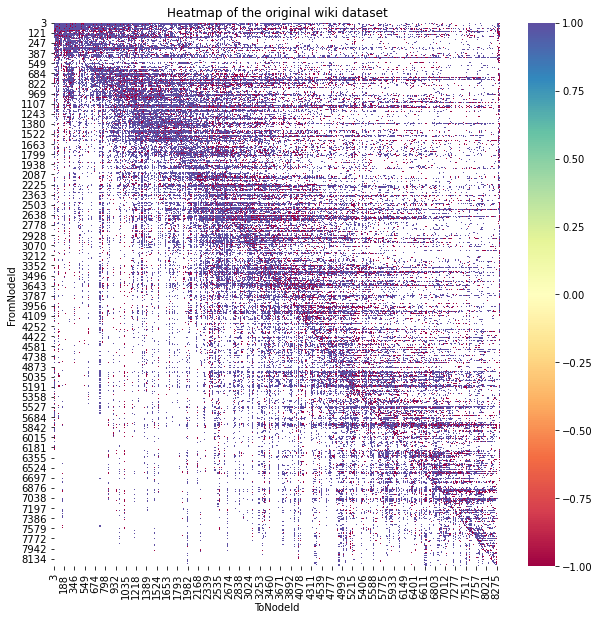

In [16]:
plt.figure(figsize = (10,10))

wiki_visu = wikiinv_df.pivot('FromNodeId', 'ToNodeId', 'Sign')
ax = sns.heatmap(wiki_visu, cmap = "Spectral")
ax.set_title('Heatmap of the original wiki dataset')